In [1]:
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
import io
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

In [2]:
tickers = ['%5EGSPTSE','%5EGSPC','%5ESTOXX','000001.SS']

data = None
while data is None:
    try:
        data = getdata(tickers,'946610000','1539644400','1d')
    except:
         pass

data['%5EGSPC'].tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-09,2882.510010,2894.830078,2874.270020,2880.340088,2880.340088,3520500000
2018-10-10,2873.899902,2874.020020,2784.860107,2785.679932,2785.679932,4501250000
2018-10-11,2776.870117,2795.139893,2710.510010,2728.370117,2728.370117,4890630000
2018-10-12,2770.540039,2775.770020,2729.439941,2767.129883,2767.129883,3966040000
2018-10-15,2763.830078,2775.989990,2749.030029,2750.790039,2750.790039,3300140000


In [3]:
boughtSP = float(data['%5EGSPC']['Adj Close'][:1])
soldSP = data['%5EGSPC']['Adj Close']
BuyHoldSP = soldSP/boughtSP-1

boughtTSX = float(data['%5EGSPTSE']['Adj Close'][:1])
soldTSX = data['%5EGSPTSE']['Adj Close']
BuyHoldTSX = soldTSX/boughtTSX-1

boughtSTOXX = float(data['%5ESTOXX']['Adj Close'][:1])
soldSTOXX = data['%5ESTOXX']['Adj Close']
BuyHoldSTOXX = soldSTOXX/boughtSTOXX-1

boughtSSE = float(data['000001.SS']['Adj Close'][:1])
soldSSE = data['000001.SS']['Adj Close']
BuyHoldSSE = soldSSE/boughtSSE-1

BuyHoldAll = (BuyHoldSP*(1/4)+BuyHoldTSX*(1/4)+
              BuyHoldSTOXX*(1/4)+BuyHoldSSE*(1/4)).fillna(method='ffill')

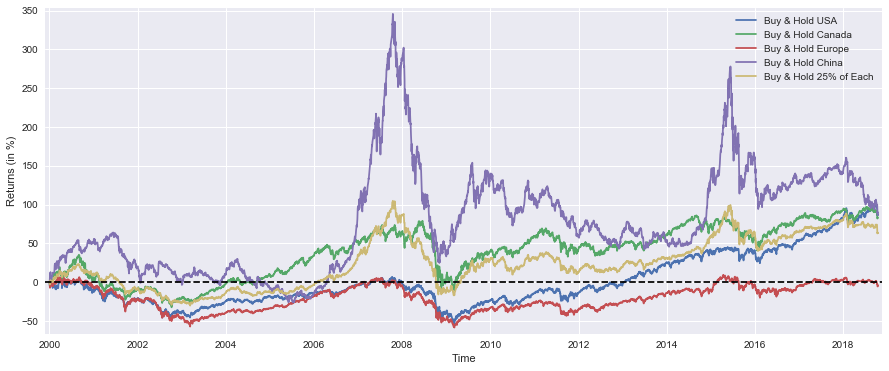

In [4]:
plt.figure(figsize=(15,6))
#=============================================================================================
plt.plot(BuyHoldSP*100, label='Buy & Hold USA')
plt.plot(BuyHoldTSX*100, label='Buy & Hold Canada')
plt.plot(BuyHoldSTOXX*100, label='Buy & Hold Europe')
plt.plot(BuyHoldSSE*100, label='Buy & Hold China')
plt.plot(BuyHoldAll*100, label='Buy & Hold 25% of Each')
# if you wish to hide a graph add # before the code of the respective graph
#=============================================================================================
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [5]:
bought1ySP = data['%5EGSPC']['Adj Close'].shift(252)
BuyHold1ySP = soldSP/bought1ySP-1

bought1yTSX = data['%5EGSPTSE']['Adj Close'].shift(252)
BuyHold1yTSX = soldTSX/bought1yTSX-1

bought1ySTOXX = data['%5ESTOXX']['Adj Close'].shift(252)
BuyHold1ySTOXX = soldSTOXX/bought1ySTOXX-1

bought1ySSE = data['000001.SS']['Adj Close'].shift(252)
BuyHold1ySSE = soldSSE/bought1ySSE-1

BuyHold1yAll = (BuyHold1ySP*(1/4)+BuyHold1yTSX*(1/4)+
                BuyHold1ySTOXX*(1/4)+BuyHold1ySSE*(1/4)).fillna(method='ffill')

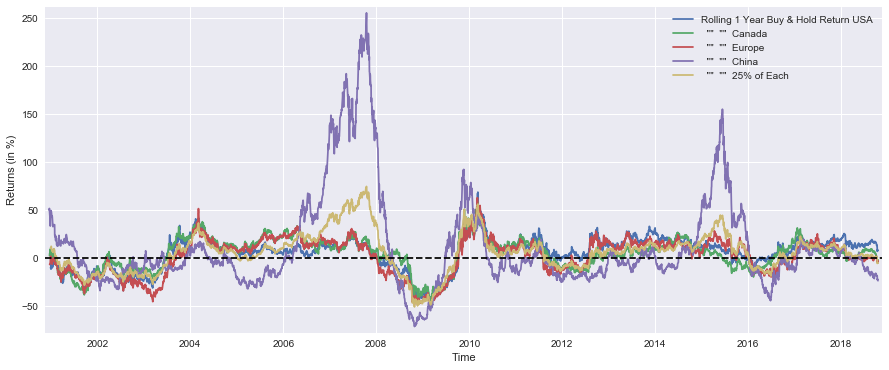

In [6]:
plt.figure(figsize=(15,6))
#=============================================================================================
plt.plot(BuyHold1ySP*100, label='Rolling 1 Year Buy & Hold Return USA')
plt.plot(BuyHold1yTSX*100, label='  ""  ""  Canada')
plt.plot(BuyHold1ySTOXX*100, label='  ""  ""  Europe')
plt.plot(BuyHold1ySSE*100, label='  ""  ""  China')
plt.plot(BuyHold1yAll*100, label='  ""  ""  25% of Each')
# if you wish to hide a graph add # before the code of the respective graph
#=============================================================================================
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [7]:
marr = 0 #minimal acceptable rate of return (communally equall to the risk free rate)
SP1YS = (BuyHold1ySP.mean()-marr)/BuyHold1ySP.std()
TSX1YS = (BuyHold1yTSX.mean()-marr)/BuyHold1yTSX.std()
STOXX1YS = (BuyHold1ySTOXX.mean()-marr)/BuyHold1ySTOXX.std()
SSE1YS = (BuyHold1ySSE.mean()-marr)/BuyHold1ySSE.std()
All1YS = (BuyHold1yAll.mean()-marr)/BuyHold1yAll.std()

print('SP500 1 Year Buy & Hold Sharpe Ratio =',round(SP1YS,2))
print('TSX "" "" =',round(TSX1YS,2))
print('STOXX600 "" "" =',round(STOXX1YS,2))
print('SSE "" "" =',round(SSE1YS,2))
print('25% of Each "" "" =',round(All1YS,2))

SP500 1 Year Buy & Hold Sharpe Ratio = 0.31
TSX "" "" = 0.26
STOXX600 "" "" = 0.11
SSE "" "" = 0.22
25% of Each "" "" = 0.28


In [8]:
SP1YD = (BuyHold1ySP.mean()-marr)/BuyHold1ySP[BuyHold1ySP < 0].std()
TSX1YD = (BuyHold1yTSX.mean()-marr)/BuyHold1yTSX[BuyHold1yTSX < 0].std()
STOXX1YD = (BuyHold1ySTOXX.mean()-marr)/BuyHold1ySTOXX[BuyHold1ySTOXX < 0].std()
SSE1YD = (BuyHold1ySSE.mean()-marr)/BuyHold1ySSE[BuyHold1ySSE < 0].std()
All1YD = (BuyHold1yAll.mean()-marr)/BuyHold1yAll[BuyHold1yAll < 0].std()

print('SP500 1 Year Buy & Hold Sortino Ratio =',round(SP1YD,2))
print('TSX "" "" =',round(TSX1YD,2))
print('STOXX600 "" "" =',round(STOXX1YD,2))
print('SSE "" "" =',round(SSE1YD,2))
print('25% of Each "" "" =',round(All1YD,2))

SP500 1 Year Buy & Hold Sortino Ratio = 0.45
TSX "" "" = 0.41
STOXX600 "" "" = 0.17
SSE "" "" = 0.8
25% of Each "" "" = 0.49


In [9]:
from scipy.optimize import minimize

def multi(x):
    a, b, c, d = x
    return a, b, c, d

def maximize_sharpe(x):
    weights = (BuyHold1ySP*(multi(x)[0])+BuyHold1yTSX*(multi(x)[1])+
               BuyHold1ySTOXX*(multi(x)[2])+BuyHold1ySSE*(multi(x)[3])).fillna(method='ffill')
    return -(weights.mean()/weights.std())

def constraint(x):
    return 1 - (multi(x)[0]+multi(x)[1]+multi(x)[2]+multi(x)[3])

cons = ({'type':'ineq','fun':constraint})
bnds = ((0,1),(0,1),(0,1),(0,1))
initial_guess = (0.25, 0.25, 0.25, 0.25)

opti = minimize(maximize_sharpe, initial_guess, method='SLSQP', bounds=bnds, constraints=cons)

optBuyHoldAll = (BuyHoldSP*(round(opti.x[0],1))+BuyHoldTSX*(round(opti.x[1],1))+
                 BuyHoldSTOXX*(round(opti.x[2],1))+BuyHoldSSE*(round(opti.x[3],1))).fillna(method='ffill')

optBuyHold1yAll = (BuyHold1ySP*(round(opti.x[0],1))+BuyHold1yTSX*(round(opti.x[1],1))+
                   BuyHold1ySTOXX*(round(opti.x[2],1))+BuyHold1ySSE*(round(opti.x[3],1))).fillna(method='ffill')

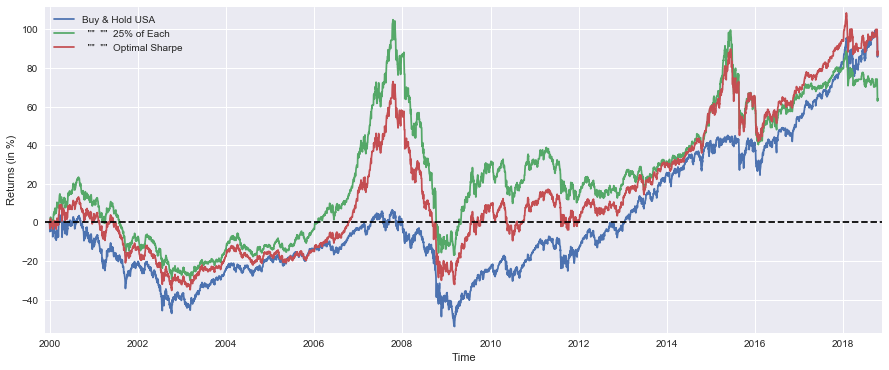

In [10]:
plt.figure(figsize=(15,6))
plt.plot(BuyHoldSP*100, label='Buy & Hold USA')
plt.plot(BuyHoldAll*100, label='  ""  ""  25% of Each')
plt.plot(optBuyHoldAll*100, label='  ""  ""  Optimal Sharpe')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

In [11]:
print('SP500 Weight =',round(opti.x[0],1)*100,'%')
print('TSX "" =',round(opti.x[1],1)*100,'%')
print('STOXX600 "" =',round(opti.x[2],1)*100,'%')
print('SSE "" =',round(opti.x[3],1)*100,'%')
print()
print('Optimal Sharpe =',round(abs(opti.fun),3))

SP500 Weight = 80.0 %
TSX "" = 0.0 %
STOXX600 "" = 0.0 %
SSE "" = 20.0 %

Optimal Sharpe = 0.339


In [12]:
print('Median yearly excess return over SP500 =',round((optBuyHold1yAll.median()-BuyHold1ySP.median())*100,1),'%')
print('"" "" "" "" over Equall Weights =',round((optBuyHold1yAll.median()-BuyHold1yAll.median())*100,1),'%')
print()
print('Optimal Sharpe YTD Performance (at 16/10/2018) =',round(float(optBuyHold1yAll[-1:]*100),1),'%')
print('S&P500 Buy & Hold "" "" (at 16/10/2018) =',round(float(BuyHold1ySP[-1:]*100),1),'%')

Median yearly excess return over SP500 = -1.1 %
"" "" "" "" over Equall Weights = 1.7 %

Optimal Sharpe YTD Performance (at 16/10/2018) = 1.6 %
S&P500 Buy & Hold "" "" (at 16/10/2018) = 7.7 %
